# 1. Installs and imports

The next cells install and import the needed packages to execute the code.

In [ ]:
!pip3 install pandas numpy nltk matplotlib evaltools

In [ ]:
import nltk
nltk.download('all')

In [ ]:
#Set a seed to produce reproducible results
import random
random.seed(10)

In [ ]:
#Imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import string as st
import re
from nltk import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import label_binarize, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score, average_precision_score, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay, PrecisionRecallDisplay
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from random import randint, sample

In [ ]:
# Set the root_path to your directory
root_path='/path/to/directory/'

# 2. Dataset preparation

* First ten rows of the dataset:

In [ ]:
# Read the data. 
data = pd.read_json(root_path, lines=True)
data.head(10)

* Size of the dataset:

In [ ]:
data.shape

*   Number of items per category:

In [ ]:
#Count number of items per category
hl_count = data.groupby('category').count()['headline']
#hl_count.sort_values(0)

plt.figure(figsize=(10,5))
y_pos = np.arange(len(hl_count.index))

plt.bar(y_pos, hl_count.values, align='center', alpha=0.5)
plt.xticks(y_pos, hl_count.index)
plt.ylabel('Number of headlines')
plt.xticks(rotation=90)
plt.title('Categories')

plt.show()

We filter the data according to the categories 'POLITICS', 'WELLNESS', 'ENTERTAINMENT', 'TRAVEL' and 'STYLE & BEAUTY'.

In [ ]:
categories = ['POLITICS', 'WELLNESS', 'ENTERTAINMENT', 'TRAVEL', 'STYLE & BEAUTY']
data = data.loc[data['category'].isin(categories)]
data = data.reset_index(drop=True)
data

New size of the dataset:

In [ ]:
data.shape

# 3. Text cleaning and processing steps

The next steps were followed to clean the text in the headline column:

1.   Convert all the text into lower case.
2.   Remove punctuations.
2.   Convert text into tokens.
3.   Remove stopwords using NLTK corpus stopwords list to match them.
4.   Apply lemmatization.
5.   Convert words to feature vectors.

In [ ]:
# Remove all punctuations from the text
def remove_punct(text):
    return ("".join([ch for ch in text if ch not in st.punctuation]))

In [ ]:
# Convert text to lower case tokens
def tokenize(text):
    text = re.split('\s+' ,text)
    return [x.lower() for x in text]

In [ ]:
# Remove tokens of length less than 3
def remove_small_words(text):
    return [x for x in text if len(x) > 3 ]

In [ ]:
# Remove stopwords using NLTK corpus list
def remove_stopwords(text):
    return [word for word in text if word not in nltk.corpus.stopwords.words('english')]

In [ ]:
# Apply lemmatization on tokens
def lemmatize(text):
    word_net = WordNetLemmatizer()
    return [word_net.lemmatize(word) for word in text]

In [ ]:
# Create sentences to get clean text as input for vectors
def return_sentences(tokens):
    return " ".join([word for word in tokens])

In [ ]:
#Apply preprocessing to text
def preprocess(text):
  return return_sentences(lemmatize(remove_stopwords(remove_small_words(tokenize(remove_punct(text).lower())))))

In [ ]:
data['clean_headline'] = data['headline'].apply(lambda x : preprocess(x))
data.head()

,category,headline,authors,link,short_description,date,clean_headline
0,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,smith join diplo nicky 2018 world cup official...
1,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,hugh grant marries first time
2,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,carrey blast castrato adam schiff democrat art...
3,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,julianna margulies us donald trump poop bag pick
4,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,Ron Dicker,https://www.huffingtonpost.com/entry/morgan-fr...,"""It is not right to equate horrific incidents ...",2018-05-26,morgan freeman devastated sexual harassment cl...


After the text cleaning, it was applied the **TF-IDF**. 

The dataset was divided into training and test with the next percentages:

* Train size: 0.75
* Test size: 0.25

In [ ]:
headlines=data["clean_headline"]
labels=data["category"]

X_train, X_test, Y_train, Y_test = train_test_split(headlines, labels, train_size=0.75, test_size=0.25, random_state=42)

In [ ]:
# Convert lemmatized words to Tf-Idf feature vectors
tfidf = TfidfVectorizer()
tfidf_train_headline = tfidf.fit_transform(X_train)
print(tfidf_train_headline.shape)

# 4. Model building

We have selected the **SVC model** as it was the most accurate.

In [ ]:
clf = LinearSVC(C=0.7, class_weight='balanced', loss='hinge', penalty='l2', random_state=9)

clf.fit(tfidf_train_headline, Y_train)

LinearSVC(C=0.7, class_weight='balanced', loss='hinge', random_state=9)

In [ ]:
tfidf_test_headline = tfidf.transform(X_test)
pred_headline = clf.predict(tfidf_test_headline)

# 5. Evaluation of the model

In [ ]:
#Encode categories
le = LabelEncoder()
data['category'] = le.fit_transform(data.category)
classes = list(le.classes_)
print(classes)

In [ ]:
# Function that computes the evaluation of a model
def evaluate(data, model):
  print("The accuracy of the model is: " + str(accuracy_score(data, model)))
  print("The balanced accuracy of the model is: " + str(balanced_accuracy_score(data, model)))
  print("The classification report of the model is: \n" + str(classification_report(data, model)))
  #print("The mean average precision of the model is: " + str(average_precision_score(data,model)))
  cm = confusion_matrix(data, model)
  print("The confusion matrix is: ")

  cm_display = ConfusionMatrixDisplay(cm,display_labels=classes)
  cm_display.plot(xticks_rotation=69)
  rocCurve(data,model)
  precRecCurve(data,model)

def precRecCurve(data,model):
  plt.figure(figsize=(10,5))

  n_classes = len(classes)
  y_test = label_binarize(data, classes=classes)
  y_pred = label_binarize(model, classes=classes)

  # precision recall curve
  precision = dict()
  recall = dict()
  for i in range(n_classes):
      precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                          y_pred[:, i])
      plt.plot(recall[i], precision[i], lw=2, label=classes[i])
      
  plt.xlabel("recall")
  plt.ylabel("precision")
  plt.legend(loc="best")
  plt.title("precision vs. recall curve")
  plt.show()

def rocCurve(data,model):
  y_test = label_binarize(data, classes=classes)
  y_pred = label_binarize(model, classes=classes)

  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  
  n_classes = len(classes)
  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # Plot all ROC curves
  plt.figure(figsize=(10,5))
  lw = 2
  plt.plot(fpr["micro"], tpr["micro"],
              label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
              color="tab:pink", linestyle=":", linewidth=4,)

  plt.plot(fpr["macro"], tpr["macro"],
              label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
              color="tab:gray", linestyle=":", linewidth=4,)

  colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
  #colors = ["tab:blue", "tab:orange", "tab:green"]
  for i, color in enumerate(colors):
      type_class = str(classes[i])
      plt.plot(fpr[i], tpr[i], color=color, lw=lw, 
                  label="ROC curve of " + type_class +" (area = {1:0.2f})".format(i, roc_auc[i]),)
  plt.plot([0, 1], [0, 1], "k--", lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("ROC curve")
  plt.legend()
  

The accuracy of the model is: 0.8748375116063138
The balanced accuracy of the model is: 0.8655799107789865
The classification report of the model is: 
                precision    recall  f1-score   support

 ENTERTAINMENT       0.86      0.82      0.84      4133
      POLITICS       0.93      0.91      0.92      8078
STYLE & BEAUTY       0.85      0.87      0.86      2397
        TRAVEL       0.83      0.85      0.84      2449
      WELLNESS       0.83      0.87      0.85      4483

      accuracy                           0.87     21540
     macro avg       0.86      0.87      0.86     21540
  weighted avg       0.88      0.87      0.88     21540

The confusion matrix is: 


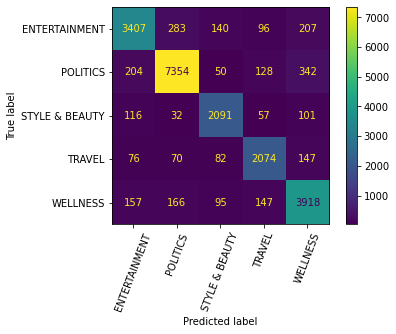

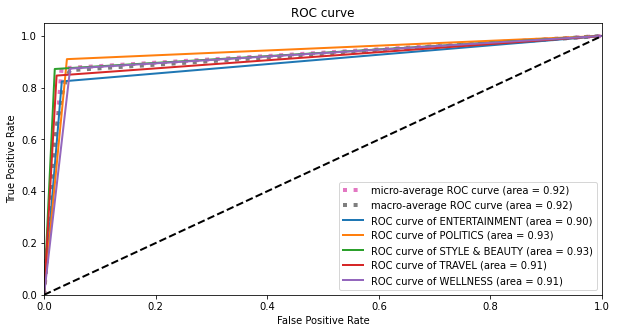

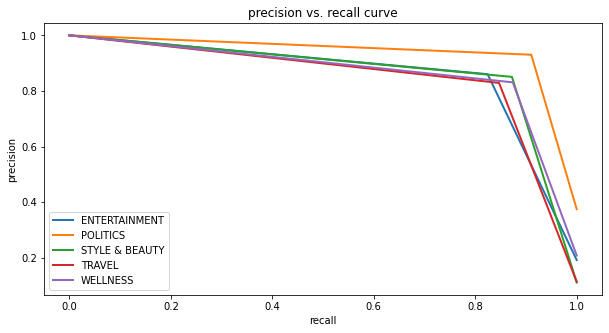

In [ ]:
evaluate(Y_test,pred_headline)

# 6. User generation

In [ ]:
#We created a class user to generate users and their preferences
class User:
  def __init__(self, id, hobbies):
    self.id = id
    self.hobbies = hobbies

  def getHobbies(self):
    return self.hobbies
  
  def addHobby(self,hobby):
    self.hobbies.append(hobby)
  
  def delHobby(self,hobby):
    self.hobbies.remove(hobby)

In [ ]:
#We define some functions to create the users list and recommend a topic to the list of users
def getTopic(text, model):
    preText = preprocess(text)  
    tfidfText = tfidf.transform([preText])
    return model.predict(tfidfText)

def create_users(num_users):
    user_list = []
    for id in range(0, num_users):
        hobbies = sample(categories, randint(1, len(categories)))
        user_list.append(User(id, hobbies))
    return user_list

def recommend(users, text, model):
    recommendations=[]
    topic = getTopic(text, model)
    for user in users:
        if topic in user.getHobbies():
            recommendations.append(user.id)
    return (topic,recommendations)

# 7. Simulation

Create a number of users and introduce a new headline. It will ​return the id of the users who should be recommended your headline.

In [ ]:
NUM_USERS = int(input("Introduce the number of users to create: "))

users = create_users(NUM_USERS)
for i in users:
  print(f"User ID: {i.id} ;   Topics of interest: {i.hobbies}")

print("")
input_query = input("Introduce new headline: ")
print("")

user_recommendations = recommend(users, input_query, clf)
print(f"Topic of the user news: {user_recommendations[0]}")
print(f"Recommended to users with ID: {user_recommendations[1]}")

Introduce the number of users to create: 5
User ID: 0 ;   Topics of interest: ['TRAVEL', 'ENTERTAINMENT', 'STYLE & BEAUTY', 'WELLNESS', 'POLITICS']
User ID: 1 ;   Topics of interest: ['ENTERTAINMENT', 'WELLNESS', 'STYLE & BEAUTY', 'POLITICS']
User ID: 2 ;   Topics of interest: ['STYLE & BEAUTY', 'POLITICS', 'ENTERTAINMENT']
User ID: 3 ;   Topics of interest: ['STYLE & BEAUTY', 'TRAVEL']
User ID: 4 ;   Topics of interest: ['POLITICS']

Introduce new headline: Presidential elections in Jamaica

Topic of the user news: ['POLITICS']
Recommended to users with ID: [0, 1, 2, 4]
